In [14]:
import os
import time 
import numpy as np 
import pandas as pd
import json
from sklearn.feature_selection import SelectKBest, f_regression, f_classif
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold

In [15]:
BASE_PATH = "../data/processed"
TRAIN_PATHS = [
    "X_train_con_outliers.csv",
    "X_train_sin_outliers.csv",
]
TEST_PATHS = [
    "X_test_con_outliers.csv",
    "X_test_sin_outliers.csv"
]

# Leer los datasets de entrenamiento y prueba
TRAIN_DATASETS = [pd.read_csv(os.path.join(BASE_PATH, path)) for path in TRAIN_PATHS] # X_train 
TEST_DATASETS = [pd.read_csv(os.path.join(BASE_PATH, path)) for path in TEST_PATHS] # X_test

# Leer las etiquetas (target) de entrenamiento y prueba
y_train = pd.read_csv(os.path.join(BASE_PATH, "y_train.csv")).values.ravel()
y_test = pd.read_csv(os.path.join(BASE_PATH, "y_test.csv")).values.ravel()

In [16]:
all_selected_features = {}
model_results = []
k = 7

for index, dataset in enumerate(TRAIN_DATASETS):
    print(f"Procesando dataset {index + 1}")

    # Selección de características usando SelectKBest con f_classif (para clasificación)
    selector = SelectKBest(f_classif, k=k)
    X_train = selector.fit_transform(dataset, y_train)  # Ajuste y transformación para el conjunto de entrenamiento
    X_test = selector.transform(TEST_DATASETS[index])  # Transformación para el conjunto de prueba

    # Almacenar las características seleccionadas en el diccionario
    selected_features = dataset.columns[selector.get_support()].tolist()  # Obtener los nombres de las características seleccionadas
    all_selected_features[TRAIN_PATHS[index]] = selected_features  # Usar el nombre del archivo como clave

    ### ENTRENAR MODELO ###

    # Crear y entrenar el modelo de regresión logística (clasificación)
    model = DecisionTreeClassifier(random_state = 42)  ### Asegúrate de ajustar los parámetros según sea necesario!!! 
    model.fit(X_train, y_train)

    # Predicciones en los datos de entrenamiento y prueba
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)

    # Calculo para los datos de entrenamiento
    accuracy_train = accuracy_score(y_train, y_train_pred)
    precision_train = precision_score(y_train, y_train_pred, average='weighted')  # Asegúrate de ajustar el 'average'
    recall_train = recall_score(y_train, y_train_pred, average='weighted')
    f1_train = f1_score(y_train, y_train_pred, average='weighted')

    # Calculo para los datos de prueba
    accuracy_test = accuracy_score(y_test, y_test_pred)
    precision_test = precision_score(y_test, y_test_pred, average='weighted')
    recall_test = recall_score(y_test, y_test_pred, average='weighted')
    f1_test = f1_score(y_test, y_test_pred, average='weighted')

    model_results.append(
    {
        "dataset_TRAIN": TRAIN_PATHS[index],  
        "dataset_TEST": TEST_PATHS[index],    
        "accuracy_train": accuracy_train,  
        "accuracy_test": accuracy_test, 
        "precision_train": precision_train,  
        "precision_test": precision_test,  
        "recall_train": recall_train,  
        "recall_test": recall_test,  
        "f1_train": f1_train,  
        "f1_test": f1_test,  
    }
)
    
model

Procesando dataset 1
Procesando dataset 2


DecisionTreeClassifier(random_state=42)

In [17]:
### GUARDAR RESULTADOS 

df_results = pd.DataFrame(model_results)

# Guardar los resultados en un archivo JSON
with open(os.path.join(f"../models/model_results_k_{k}.json"), 'w') as json_file:
    json.dump(model_results, json_file, indent=4)

# Guardar las características seleccionadas en un solo archivo JSON
with open(os.path.join(f"../models/selected_features_k_{k}.json"), 'w') as json_file:
    json.dump(all_selected_features, json_file, indent=4)


### MUESTRA RESULTADOS ###

print(f"Resultados de todos los datasets con k: {k}:")
print(df_results.to_string(index=False))

best_dataset_index = df_results["accuracy_test"].idxmax()  
best_dataset = df_results.iloc[best_dataset_index]

print("\nEl mejor dataset seleccionado según la mayor precisión en el conjunto de prueba:")
print(best_dataset[["accuracy_train", "accuracy_test"]])


print(f"\nEl mejor dataset de entrenamiento es: {TRAIN_PATHS[best_dataset_index]}")
print(f"El mejor dataset de prueba es: {TEST_PATHS[best_dataset_index]}")

print("Confusion Matrix:\n", confusion_matrix(y_test, y_test_pred))

Resultados de todos los datasets con k: 7:
           dataset_TRAIN            dataset_TEST  accuracy_train  accuracy_test  precision_train  precision_test  recall_train  recall_test  f1_train  f1_test
X_train_con_outliers.csv X_test_con_outliers.csv             1.0        0.75974              1.0        0.771652           1.0      0.75974       1.0 0.763105
X_train_sin_outliers.csv X_test_sin_outliers.csv             1.0        0.74026              1.0        0.750916           1.0      0.74026       1.0 0.743596

El mejor dataset seleccionado según la mayor precisión en el conjunto de prueba:
accuracy_train        1.0
accuracy_test     0.75974
Name: 0, dtype: object

El mejor dataset de entrenamiento es: X_train_con_outliers.csv
El mejor dataset de prueba es: X_test_con_outliers.csv
Confusion Matrix:
 [[75 24]
 [16 39]]


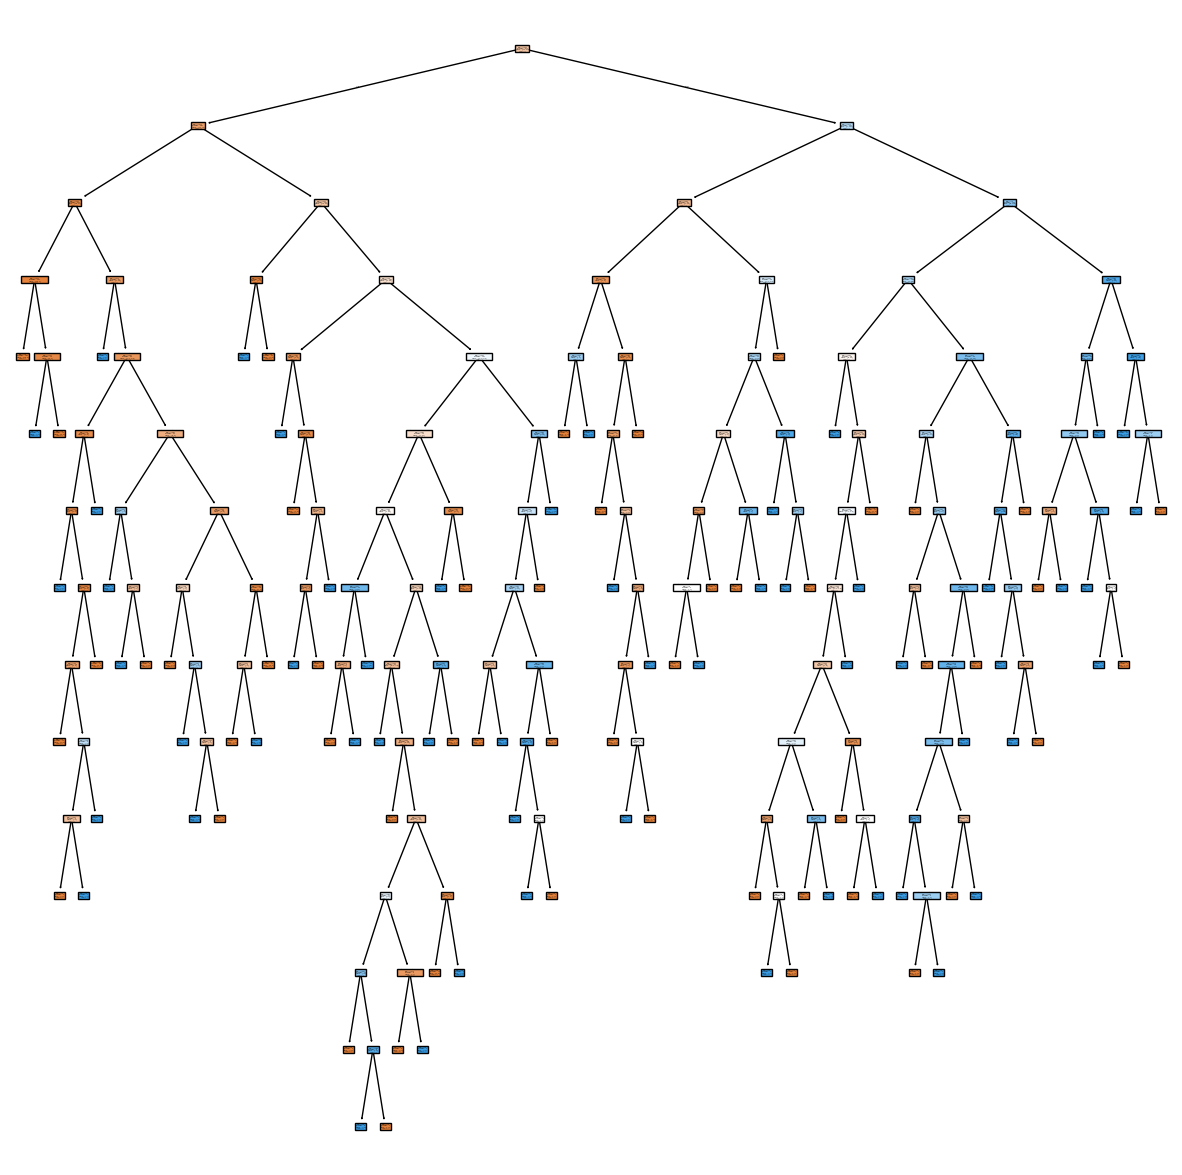

In [18]:
import matplotlib.pyplot as plt
from sklearn import tree

fig = plt.figure(figsize=(15,15))

tree.plot_tree(model, feature_names=selected_features, class_names=["0", "1", "2"], filled=True)

plt.show()

OPTMIZACIÓN

In [19]:
start_time = time.time()

model = DecisionTreeClassifier(random_state = 42) 
param_grid = {
    'max_depth': [2, 10, 20, 50, 100],  # Ampliar para cubrir más posibilidades de profundidad
    'min_samples_split': [2, 5, 10, 20],  # Valores de partición más variados
    'min_samples_leaf': [2, 5, 10, 20],  # Asegurarse de que no haya nodos hoja con pocos datos
    'max_features': ['sqrt', 'log2', 2, 4],  # Usar 'sqrt', 'log2' y también valores absolutos de características
    'criterion': ['gini', 'entropy'],  # Evaluar con ambos criterios
    'splitter': ['best'],  # 'best' es generalmente mejor
    'class_weight': ['balanced', None],  # Probar con y sin balanceo de clases
    'min_impurity_decrease': [0.0, 0.01, 0.02],  # Probar diferentes niveles de impureza mínima
    'max_leaf_nodes': [None, 10, 20, 50],  # Limitar el número de nodos hoja para controlar el sobreajuste
    'ccp_alpha': [0.0, 0.01, 0.05, 0.1],  # Buscar un rango más amplio de valores para la poda
}

# Configuración de GridSearchCV con validación cruzada estratificada
grid = GridSearchCV(
    model,
    param_grid=param_grid,
    cv=StratifiedKFold(n_splits=10, shuffle=True, random_state=42),  # Validación cruzada estratificada
    n_jobs=-1,  # Utilizar todos los núcleos disponibles
    verbose=3,  # Nivel 3 de detalle en la salida de la búsqueda
    scoring='accuracy',  # Evaluar en función de la precisión
    refit=True,  # Volver a entrenar el modelo con los mejores parámetros encontrados
    return_train_score=True,  # Para obtener también las puntuaciones de entrenamiento
)

# Ajustar el modelo con el conjunto de entrenamiento filtrado
grid.fit(X_train, y_train)
final_model = grid.best_estimator_

# Predicciones en los datos de entrenamiento y prueba
y_pred_train = final_model.predict(X_train)
y_pred_test = final_model.predict(X_test)

end_time = time.time()
execution_time = end_time - start_time

data_to_save = {
    "hyperparams": grid.best_params_,
    "train_accuracy": accuracy_score(y_train, y_pred_train),
    "test_accuracy": accuracy_score(y_test, y_pred_test),
    "train_predictions": y_pred_train.tolist(),
    "test_predictions": y_pred_test.tolist(),
}

# Guardamos los resultados en un archivo JSON
with open(os.path.join("../models/hyperparams.json"), "w") as json_file:
    json.dump(data_to_save, json_file, indent=4)

print(f"Tiempo de ejecución: {execution_time / 60:.0f} minutos")
print(f"Training Accuracy: {accuracy_score(y_train, y_pred_train) * 100:.4f}")
print(f"Test Accuracy: {accuracy_score(y_test, y_pred_test) * 100:.4f}")

Fitting 10 folds for each of 61440 candidates, totalling 614400 fits
Tiempo de ejecución: 29 minutos
Training Accuracy: 85.6678
Test Accuracy: 72.0779


In [20]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

acc = accuracy_score(y_test, y_pred_test)
prec = precision_score(y_test, y_pred_test)
rec = recall_score(y_test, y_pred_test)
f1 = f1_score(y_test, y_pred_test)
cm = confusion_matrix(y_test, y_pred_test)
print("Accuracy:", acc)
print("Precision:", prec)
print("Recall:", rec)
print("F1 Score:", f1)
print("Confusion Matrix:\n", cm)

Accuracy: 0.7207792207792207
Precision: 0.62
Recall: 0.5636363636363636
F1 Score: 0.5904761904761905
Confusion Matrix:
 [[80 19]
 [24 31]]


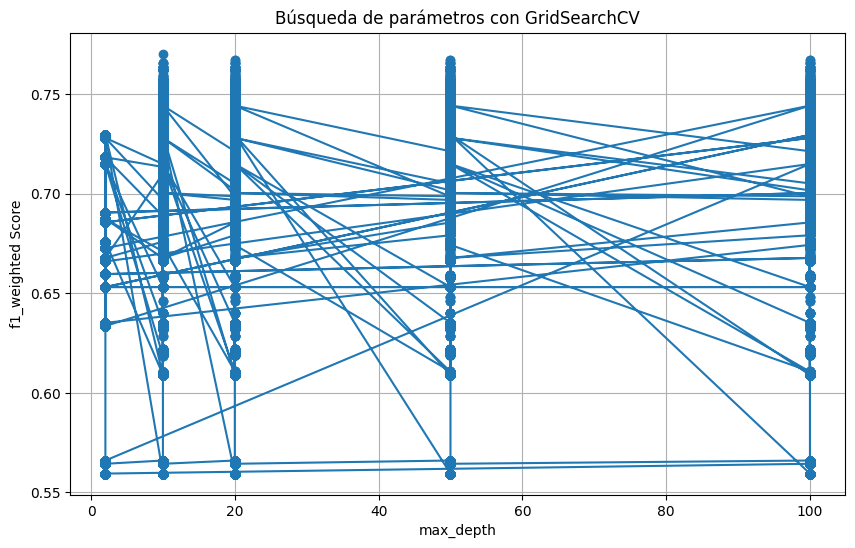

In [21]:
# Extraer los resultados del GridSearchCV
results = grid.cv_results_

# Gráfica del f1_weighted vs max_depth
plt.figure(figsize=(10, 6))
plt.plot(results['param_max_depth'], results['mean_test_score'], marker='o', label='f1_weighted')
plt.xlabel('max_depth')
plt.ylabel('f1_weighted Score')
plt.title('Búsqueda de parámetros con GridSearchCV')
plt.grid(True)
plt.show()

In [22]:
import pickle

# Guardamos el modelo en un archivo con pickle
with open("../models/DecisionTree_default_42.sav", "wb") as file:
    pickle.dump(model, file)